In [5]:
!pip install matplotlib numpy

Load tracks from json

In [6]:
import json


songs = []

def lookup_category(genre):
    categories = {"house": ["afro-house", "bass-club", "bass-house", "deep-house", "funky-house", "house", "jackin-house","melodic-house-techno", "organic-house-downtempo", "progressive-house", "tech-house"],
        "techno": ["techno-peak-time-driving", "techno-raw-deep-hypnotic", "hard-techno"],
        "trance": ["trance-main-floor", "trance-raw-deep-hypnotic", "psy-trance"],
        "dubstep": ["140-deep-dubstep-grime", "drum-bass", "dubstep"],
        "edm": ["electro-classic-detroit-modern", "mainstage"],
        "dance": ["dance-electro-pop", "indie-dance", "hardcore"]}
    
    for category, subgenres in categories.items():
        if genre in subgenres:
            return category

    return None


with open(f"./tracks.json") as f:
    songs_raw = json.load(f)
    
    for song_raw in songs_raw:
        try:
            song = {"id": song_raw["id"],
                    "bpm": song_raw["bpm"],
                    "camelot_key": f'{song_raw["key"]["camelot_number"]}{song_raw["key"]["camelot_letter"]}',
                    "genre": song_raw["genre"]["slug"],
                    "category": lookup_category(song_raw["genre"]["slug"])}
            if "sub_genre" in song_raw:
                song["sub_genre"] = song_raw["sub_genre"]
            else:
                song["sub_genre"] = None
        except TypeError:
            # Incomplete data
            continue
        songs.append(song)

print(f"Total songs: {len(songs)}")

Total songs: 9999


Plotting some info about the dataset

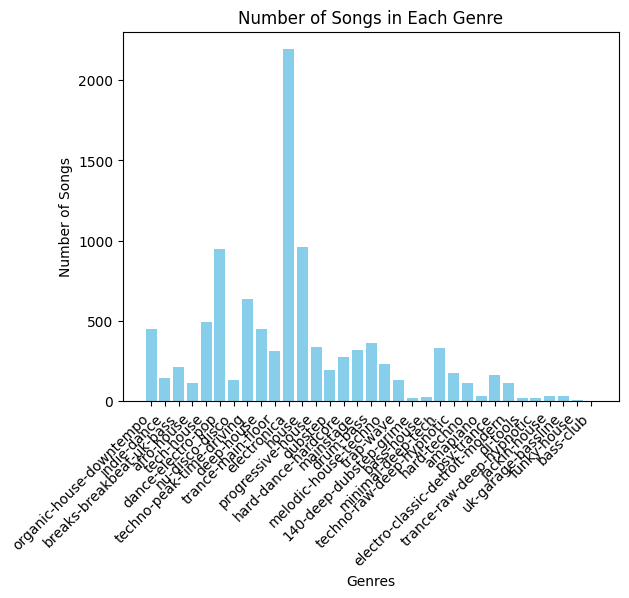

In [9]:
import matplotlib.pyplot as plt


genre_counts = {}
for song in songs:
    genre = song["genre"]
    genre_counts[genre] = genre_counts.get(genre, 0) + 1

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.bar(genres, counts, color='skyblue')
plt.xlabel('Genres')
plt.xticks(rotation=45, ha="right")
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Genre')
plt.show()

Defining distance function
Calculating distances for each set of pairs

In [13]:
def compute_song_distance(song1, song2):
    camelot_wheel = ['1A', '2A', '3A', '4A', '5A', '6A', '7A', '8A', '9A', '10A', '11A', '12A',
                     '1B', '2B', '3B', '4B', '5B', '6B', '7B', '8B', '9B', '10B', '11B', '12B']

    index1 = camelot_wheel.index(song1["camelot_key"].upper())
    index2 = camelot_wheel.index(song2["camelot_key"].upper())

    identical = index1 == index2
    adjacent = abs(index1 - index2) == 1 or abs(index1 - index2) == len(camelot_wheel) - 1

    bpm_difference = abs(song1['bpm'] - song2['bpm'])

    same_subgenre = song1['sub_genre'] == song2['sub_genre'] or song1['sub_genre'] is None
    same_genre = song1['genre'] == song2['genre']
    same_category = song1['category'] == song2['category'] or song1['category'] is None
    
    # TODO: optimize weights
    distance = ((not identical and not adjacent)
                + 0.3 * bpm_difference
                + 0.3 * (not same_category)
                + 0.3 * (not same_genre)
                + 0.3 * (not same_subgenre))

    return distance

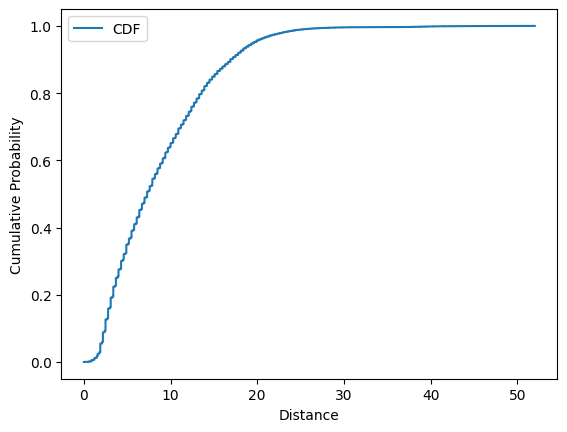

In [14]:
import numpy as np
import matplotlib.pyplot as plt


distance = []
for songA in songs:
    for songB in songs:
        if songA != songB:
            distance.append(compute_song_distance(songA, songB))

sorted_distances = np.sort(distance)
cumulative_distribution = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)

plt.plot(sorted_distances, cumulative_distribution, label='CDF')

plt.xlabel('Distance')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.show()

Getting the match score

In [15]:
def get_match_score(songA, songB):
    target_distance = compute_song_distance(songA, songB)
    index = np.argmax(sorted_distances >= target_distance)
    
    percentage_above_distance = 100 * (1 - (index / len(sorted_distances)))

    return percentage_above_distance

Testing with a random pair

In [18]:
from random import randrange

songA = songs[randrange(len(songs))]
songB = songs[randrange(len(songs))]

score = get_match_score(songA, songB)
distance = compute_song_distance(songA, songB)
print(f"Distance: {distance}; Score: {score}")

Distance: 10.900000000000002; Score: 31.880853618468464


Saving distances to file

In [21]:
np.save('./distances.npy', sorted_distances)